# **News Headlines Analysis for Stock Market Prediction**

The purpose of this project is creating a capable forecast model that uses news headline to predict the stock market trend. There is a thriving literature about the correlation between news and market trends (Alamsyah, Andry. Exploring Relationship between Headline News Sentiment and Stock Return. 2019), therefore the motivation behind this type of analysis arises from human impossibility to extract relevant information from news headlines for predicting index market trends useful in several fields, like crafting trading strategies. Regarding this, in the last years, many different approaches and tecnhologies have been emerging and affirming in the text mining and NLP field to extract relevant information from many different types of text (Cambria, Erik. Jumping NLP Curves: A Review of Natural
Language Processing Research. 2019). I have applied some of them on a Kaggle dataset which includes the top 25 daily news headlines form June 8, 2008 to July 1, 2016 and Dow Jones Industrial Average (DIJA) stock performance data during the same time period. The latter contains the OHLC (Open High Low Close) coordinates and the amount of daily volume. 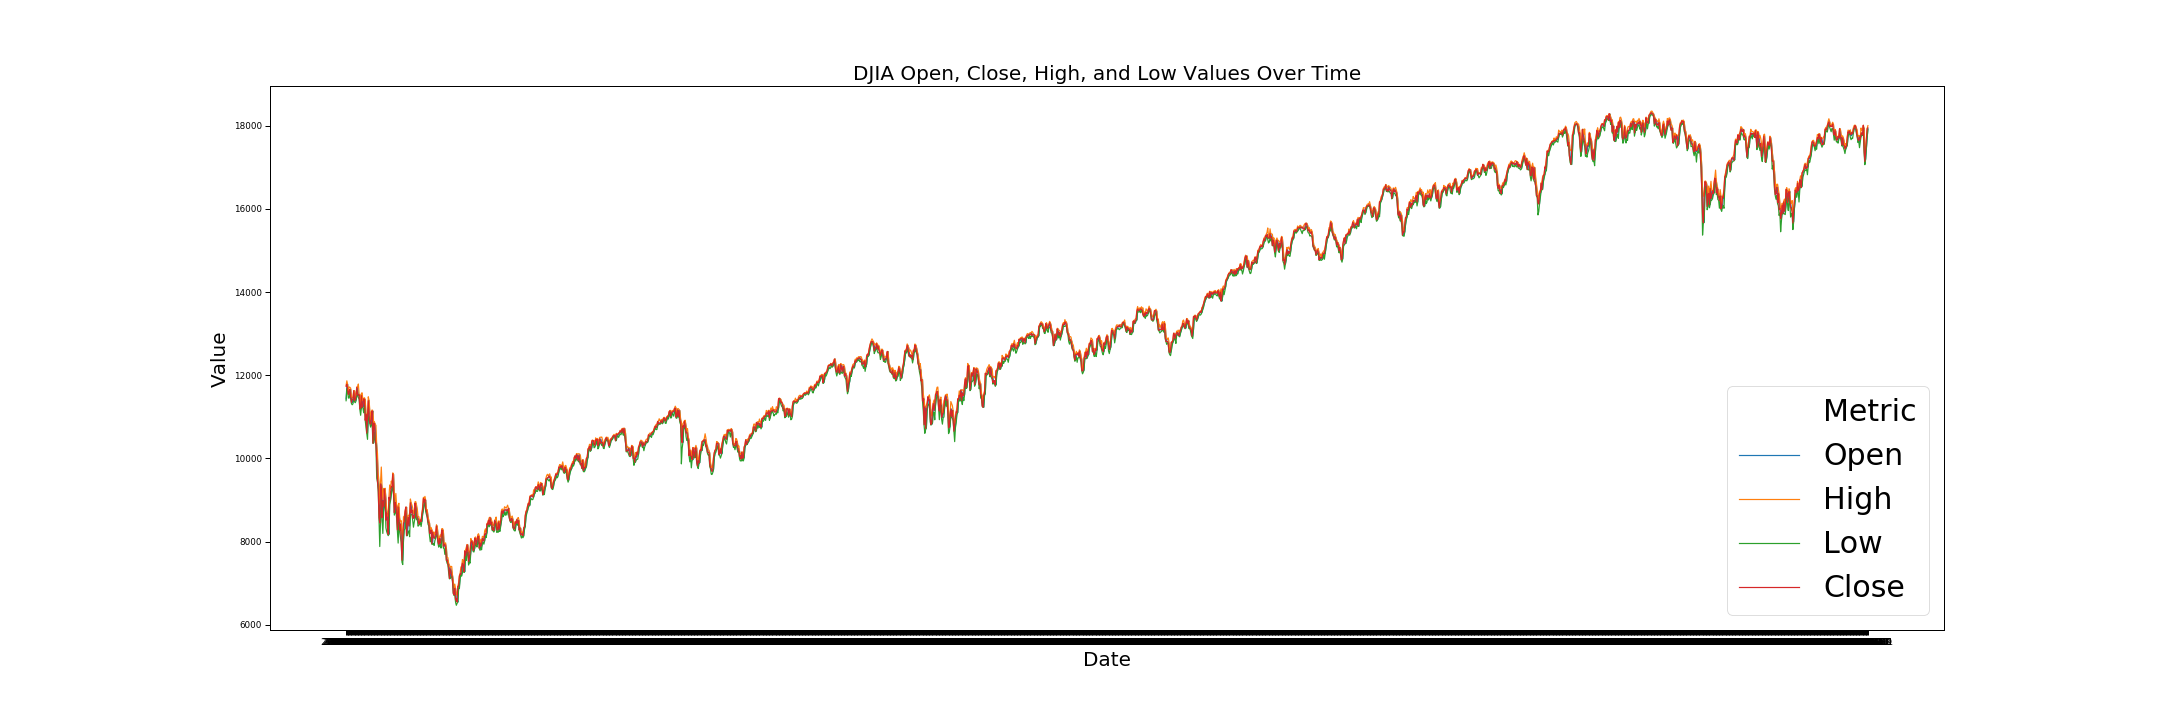

In Kaggle, several challenges have been proposed using these datasets, especially the one of predicting if the $adj.Close$ price of the day $x$ is higher or lower than the $adj.Close$ price of the day $x-1$. For this purpose, i decided to perform a preliminary analsyis of the dataset and then using the market trend as a label to train several machine learning algorithms and lastly exploiting more complex models like LSTM and xgboost.

The notebook is organized in 6 sections:

1.   Data acquisition includes the acquisition of data and a processing phase based on regular expressions
2.   Data exploration&Pre-processing to show the most interesting features of the dataset and the consequent pre-processing (stopwords, stemming, lexicon, ...)
3.   Word and sentence embedding using tf-idf and SVD (Singular Value Decompoistion) to avoid the curse of dimensionality
4.   Evaluation by trying  simple machine learning algorithms
5.   Final evaluation with LSTM and xgboost
6.   Conclusions



In [ ]:
install.packages("quanteda")
install.packages("caret")
install.packages("tm")
install.packages("e1071")
install.packages("clusterSim")

In [ ]:
library(caret)
library(quanteda)
library(tm)
library(e1071)
library(tidyverse)
library(ggplot2)
library(clusterSim)
library(stringr)
library(dplyr)

## **Data acquisition**
The news dataset is not aggregated over the date (one headline for date), therefore the first step is grouping all news headlines over the date, after the elimination of noisy patterns, performed with some regular expressions.

In [ ]:
# Reading the news dataset

news <- read.csv("news_reddit.csv", sep = ",")
matches <- str_match(news$Date, ",\".*")
news$Date <- gsub(',\".*', '', news$Date)
news$News <- paste(matches, news$News, sep = " ")
news$Date <- as.Date(news$Date)

head(news, 5)

,Date,News
,<date>,<chr>
1,2016-07-01,",""A 117-year-old woman in Mexico City finally received her birth certificate, and died a few hours later. Trinidad Alvarez Lira had waited years for proof that she had been born in 1898."""
2,2016-07-01,NA IMF chief backs Athens as permanent Olympic host
3,2016-07-01,",""The president of France says if Brexit won, so can Donald Trump"""
4,2016-07-01,NA British Man Who Must Give Police 24 Hours' Notice of Sex Threatens Hunger Strike: The man is the subject of a sexual risk order despite having never been convicted of a crime.
5,2016-07-01,NA 100+ Nobel laureates urge Greenpeace to stop opposing GMOs


In [ ]:
# Removing some noisy patterns from the news dataset

news$News <- gsub('NA ','', news$News)
news$News <- gsub('["&/()^*@#-,;+:\\]+',' ', news$News)
news$News <- gsub('\\]|\\[',' ', news$News)
news$News <- gsub('[-’‘]','', news$News)
news$News <- gsub('\r|\n|\t','', news$News)
news$News <- gsub('[?]',' ? ', news$News)
news$News <- gsub('[!]',' ! ', news$News)
news$News <- gsub('[0-9]+[.][0-9]+',' ', news$News)
news$News <- gsub('[0-9]+',' ', news$News)
news$News <- gsub('[.]',' ', news$News)

head(news, 5)

,Date,News
,<date>,<chr>
1,2016-07-01,A yearold woman in Mexico City finally received her birth certificate and died a few hours later Trinidad Alvarez Lira had waited years for proof that she had been born in
2,2016-07-01,IMF chief backs Athens as permanent Olympic host
3,2016-07-01,The president of France says if Brexit won so can Donald Trump
4,2016-07-01,British Man Who Must Give Police Hours Notice of Sex Threatens Hunger Strike The man is the subject of a sexual risk order despite having never been convicted of a crime
5,2016-07-01,Nobel laureates urge Greenpeace to stop opposing GMOs


In [ ]:
# Aggregation of the top 25 daily news by date and sorting by date

aggr.news <- aggregate(News ~ Date, data = news, paste, collapse = " ")
aggr.news$News <- gsub(' [A-Za-z]{1} |^[A-Za-z]{1} ','', aggr.news$News)
aggr.news <- aggr.news[order(aggr.news$Date),]

head(aggr.news, 5)

,Date,News
,<date>,<chr>
1,2010-06-19,Police to be considered on criminal charges after ntazeringman times who then died This would nNOT have been investigated ifbystander hadnnfilmed the police murdering him In honor of the great Manute Bol Sudan Basketball Warrior who passed away today at age after dedicating his life to improving the conditions in his native country Rest in peace you kind decent benevolent soul Priceless ! ! Israeli mission to UN caught lying while attempting to double deal the UN United Nations Correspondents Association includes email exchanges BP Tells Cleanup Workers They ll Be Fired If They Wear Respirators Italian seismologists indicted for manslaughter for not predicting magnitude earthquake Chinese security manhandle NZ Member of Parliment waving Tibetan flag in New Zealand ! North Korea lifts restrictions on private markets as last resort in food crisis Manute Bol is dead because ofskin disease he contracted while trying to improve peoplelives in Sudan Sweden gives green light to new nuclear reactors Bangladesh poisoned by arsenic in drinking water Muslims illegally occupying streets of Paris to pray depriving shop owners of business for two andhalf hours and preventing residents of the street from entering or leaving their apartments Muslim guards block the street Israel to Take Action Against Lebanese Aid Ships The belief that things will end well in Afghanistan is dwindling in Germany An increasing number of security experts recommend an orderly withdrawal and even those who were involved in sending the Bundeswehr on the mission are now voicing doubts about ultimate success Turkish Jets Raid Northern Iraq Clashes Kill A missile suspected to have been fired by an unmanned US drone is reported to have killed people and wounded seven others after it struckhouse in the Mir Ali area of PakistanNorth Waziristan
2,2010-06-20,Millions in Bangladesh poisoned by arseniccontaminated water WHO calls it the largest mass poisoning ofpopulation in history What about compensation for Bhopal ? It took years for the Indian government to obtain compensation on behalf of the victims of the Union Carbide disaster in Bhopal paltry sum compared to the fund set up by BP Missing from the World Cup ? China We re billion people canwe find at least guys who are good at soccer ? New Zealand Prime Minister apologises to China after Green Party Coleader calls for Chinese democracy andfree Tibet It looks like free trade trumps free speech A batch of about mozzarella balls which turned blue upon opening has been confiscated by food authorities in Italy officials say Germanys Development Minister Dirk Niebel has harshly criticised the Israeli government after it refused him entry into the Gaza Strip at the weekend The refusal of entry into the Gaza Strip isbig foreign policy mistake Thanks to legislation Americans are becoming financial refugees in some cases renouncing their citizenship Gaza Convoy Activists Claim Israeli Soldiers Using Debit Cards Stolen in Raid Internet Freedom under pressure in Denmark Gunmen kill mayor of border town in Mexico drug war BP Tells Cleanup Workers They ll Be Fired If They Wear Respirators DUBAI Alleged victim of gang rape sentenced to one year in prison Cost of Afghan and Iraq wars rises above billion Israel security cabinet approves loosening of Gaza blockade Haaretz Tonnes of radioactive waste casts doubt over LondonOlympic stadium legacy Olympic site could be rendered useless after the Games American Warships Including One Aircraft Carrier And One Israeli Corvette Cross Suez Canal On Way To Red Sea And Beyond Fidel Castro claims US sank South Korean ship cause nhe would know Israel is to significantly ease the Gaza blockade with all civilian goods now expected to be let into the territory and reveals Gaza blockade restrictions Pakistan FM vows to implement Iran gas pipeline project despiteS warning Chaos hits French World Cup camp ArabIsraeli Parliamentarian Fights Death Threats Israelambass

In this step the lexicon is loaded. It consists on 7 fields: each of them contains the characterizing words. It is also vaguely sentiment-analysis oriented due to the presence of the "Positive" and "Negative" categories. After that the lexicon is used to assign a score to each top 25 news istance.

In [ ]:
# Reading the lexicon dataset (Loughran-McDonald Sentiment Word Lists) 
# https://sraf.nd.edu/textual-analysis/resources/#LM%20Sentiment%20Word%20Lists

lexicon <- read.csv(file = "Lexicon.csv", sep = ";")

lexicon$Negative <- tolower(lexicon$Negative)
lexicon$Positive <- tolower(lexicon$Positive)
lexicon$Uncertainty <- tolower(lexicon$Uncertainty)
lexicon$Litigious <- tolower(lexicon$Litigious)
lexicon$Constraining <- tolower(lexicon$Constraining)
lexicon$WeakModal <- tolower(lexicon$WeakModal)
lexicon$StrongModal <- tolower(lexicon$StrongModal)

head(lexicon, 5)

,Negative,Positive,Uncertainty,Litigious,Constraining,StrongModal,WeakModal
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,abandon,able,abeyance,abovementioned,abide,always,almost
2,abandoned,abundance,abeyances,abrogate,abiding,best,apparently
3,abandoning,abundant,almost,abrogated,bound,clearly,appeared
4,abandonment,acclaimed,alteration,abrogates,bounded,definitely,appearing
5,abandonments,accomplish,alterations,abrogating,commit,definitively,appears


In this step the stock market trend dataset is loaded. All attributes, except the date, are standardized in the range (0, 1) and then shifted downwards (towards the next day) because they are relevant only "for the future" except the $Open$, which is known at the beggining of the day. Creating this shifted dataset from the original one is useful for two reasons:


1.   OLHC coordinates can be used as additive features for the machine learning algorithms
2.   It is easy to compute the label for each day by merging the shifted dataset and the original one. Let's recall that the label for each day is computed according to the following formula $Adj.Close.Day.x > Adj.Close.day.x-1$

The news dataset is also shifted following the methodology of Kavšek in "Using Words from Daily News Headlines to Predict the Movement of Stock Market Indices" in which he shows that "predicting stock value form ‘yesterday’s
news’ gives higher predictive accuracy".

In [ ]:
# Reading the financial dataset and sorting by date

stock_market_trend <- read.csv(file = "financial_reddit.csv", sep = ",")

stock_market_trend$Date <- as.Date(stock_market_trend$Date)
stock_market_trend <- stock_market_trend[order(stock_market_trend$Date),]

head(stock_market_trend, 5)

,Date,Open,High,Low,Close,Volume,Adj.Close
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
1989,2008-08-08,11432.09,11759.96,11388.04,11734.32,212830000,11734.32
1988,2008-08-11,11729.67,11867.11,11675.53,11782.35,183190000,11782.35
1987,2008-08-12,11781.70,11782.35,11601.52,11642.47,173590000,11642.47
1986,2008-08-13,11632.81,11633.78,11453.34,11532.96,182550000,11532.96
1985,2008-08-14,11532.07,11718.28,11450.89,11615.93,159790000,11615.93


In [ ]:
# Normalization of market indices 

normalize.column <- function(col) {
    (col - min(col)) / (max(col) - min(col))}

stock_market_trend$Open <- normalize.column(stock_market_trend$Open)
stock_market_trend$High <- normalize.column(stock_market_trend$High)
stock_market_trend$Low <- normalize.column(stock_market_trend$Low)
stock_market_trend$Close <- normalize.column(stock_market_trend$Close)
stock_market_trend$Volume <- normalize.column(stock_market_trend$Volume)
stock_market_trend$Adj.Close <- normalize.column(stock_market_trend$Adj.Close)

head(stock_market_trend, 5)

,Date,Open,High,Low,Close,Volume,Adj.Close
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1989,2008-08-08,0.4151138,0.4338137,0.4166951,0.4408942,0.3067021,0.4408942
1988,2008-08-11,0.4404009,0.4430176,0.4410533,0.4449765,0.2622316,0.4449765
1987,2008-08-12,0.4448222,0.4357369,0.4347826,0.4330873,0.2478282,0.4330873
1986,2008-08-13,0.4321701,0.4229751,0.4222278,0.4237795,0.2612714,0.4237795
1985,2008-08-14,0.4236097,0.4302335,0.4220202,0.4308315,0.2271234,0.4308315


In [ ]:
# Shifting the news and the financial dataset according to Kavšek https://ideas.repec.org/a/mgt/youmgt/v15y2017i2p109-121.html

shift_all_but_first <- function(data, N) data %>% mutate_at(1, ~lead(., N)) %>% slice(1:(n() - N))

stock_market_trend_shifted <- shift_all_but_first(stock_market_trend, 1)
news_shifted <- shift_all_but_first(aggr.news, 1)

colnames(stock_market_trend_shifted)[2] <- "Hist_Open"
colnames(stock_market_trend_shifted)[3] <- "Hist_High"
colnames(stock_market_trend_shifted)[4] <- "Hist_Low"
colnames(stock_market_trend_shifted)[5] <- "Hist_Close"
colnames(stock_market_trend_shifted)[6] <- "Hist_Volume"
colnames(stock_market_trend_shifted)[7] <- "Hist_Adj.Close"

stock_market_trend <- stock_market_trend[1:(dim(stock_market_trend)[1] - 1),]
news_shifted <- news_shifted[1:(dim(news_shifted)[1] - 1),]

head(stock_market_trend_shifted, 5)
head(news_shifted, 5)

,Date,Hist_Open,Hist_High,Hist_Low,Hist_Close,Hist_Volume,Hist_Adj.Close
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2008-08-11,0.4151138,0.4338137,0.4166951,0.4408942,0.3067021,0.4408942
2,2008-08-12,0.4404009,0.4430176,0.4410533,0.4449765,0.2622316,0.4449765
3,2008-08-13,0.4448222,0.4357369,0.4347826,0.4330873,0.2478282,0.4330873
4,2008-08-14,0.4321701,0.4229751,0.4222278,0.4237795,0.2612714,0.4237795
5,2008-08-15,0.4236097,0.4302335,0.4220202,0.4308315,0.2271234,0.4308315


,Date,News
,<date>,<chr>
1,2010-06-20,Police to be considered on criminal charges after ntazeringman times who then died This would nNOT have been investigated ifbystander hadnnfilmed the police murdering him In honor of the great Manute Bol Sudan Basketball Warrior who passed away today at age after dedicating his life to improving the conditions in his native country Rest in peace you kind decent benevolent soul Priceless ! ! Israeli mission to UN caught lying while attempting to double deal the UN United Nations Correspondents Association includes email exchanges BP Tells Cleanup Workers They ll Be Fired If They Wear Respirators Italian seismologists indicted for manslaughter for not predicting magnitude earthquake Chinese security manhandle NZ Member of Parliment waving Tibetan flag in New Zealand ! North Korea lifts restrictions on private markets as last resort in food crisis Manute Bol is dead because ofskin disease he contracted while trying to improve peoplelives in Sudan Sweden gives green light to new nuclear reactors Bangladesh poisoned by arsenic in drinking water Muslims illegally occupying streets of Paris to pray depriving shop owners of business for two andhalf hours and preventing residents of the street from entering or leaving their apartments Muslim guards block the street Israel to Take Action Against Lebanese Aid Ships The belief that things will end well in Afghanistan is dwindling in Germany An increasing number of security experts recommend an orderly withdrawal and even those who were involved in sending the Bundeswehr on the mission are now voicing doubts about ultimate success Turkish Jets Raid Northern Iraq Clashes Kill A missile suspected to have been fired by an unmanned US drone is reported to have killed people and wounded seven others after it struckhouse in the Mir Ali area of PakistanNorth Waziristan
2,2010-06-21,Millions in Bangladesh poisoned by arseniccontaminated water WHO calls it the largest mass poisoning ofpopulation in history What about compensation for Bhopal ? It took years for the Indian government to obtain compensation on behalf of the victims of the Union Carbide disaster in Bhopal paltry sum compared to the fund set up by BP Missing from the World Cup ? China We re billion people canwe find at least guys who are good at soccer ? New Zealand Prime Minister apologises to China after Green Party Coleader calls for Chinese democracy andfree Tibet It looks like free trade trumps free speech A batch of about mozzarella balls which turned blue upon opening has been confiscated by food authorities in Italy officials say Germanys Development Minister Dirk Niebel has harshly criticised the Israeli government after it refused him entry into the Gaza Strip at the weekend The refusal of entry into the Gaza Strip isbig foreign policy mistake Thanks to legislation Americans are becoming financial refugees in some cases renouncing their citizenship Gaza Convoy Activists Claim Israeli Soldiers Using Debit Cards Stolen in Raid Internet Freedom under pressure in Denmark Gunmen kill mayor of border town in Mexico drug war BP Tells Cleanup Workers They ll Be Fired If They Wear Respirators DUBAI Alleged victim of gang rape sentenced to one year in prison Cost of Afghan and Iraq wars rises above billion Israel security cabinet approves loosening of Gaza blockade Haaretz Tonnes of radioactive waste casts doubt over LondonOlympic stadium legacy Olympic site could be rendered useless after the Games American Warships Including One Aircraft Carrier And One Israeli Corvette Cross Suez Canal On Way To Red Sea And Beyond Fidel Castro claims US sank South Korean ship cause nhe would know Israel is to significantly ease the Gaza blockade with all civilian goods now expected to be let into the territory and reveals Gaza blockade restrictions Pakistan FM vows to implement Iran gas pipeline project despiteS warning Chaos hits French World Cup camp ArabIsraeli Parliamentarian Fights Death Threats Israelambass

Now the final dataset is obtained by merging those obtained previously.

In [ ]:
# Merging financial and news datasets and computing the label for each instance

merged_df <- merge(stock_market_trend, stock_market_trend_shifted, by.x = "Date", all.x=TRUE, all.y=TRUE)
merged_df <- merge(news_shifted, merged_df, by.x = "Date", all.x=TRUE, all.y=TRUE)

merged_df$Date <- as.Date(merged_df$Date, "%d-%b-%y")
merged_df$Label <- NULL
merged_df <- merged_df[order(merged_df$Date),]

# Trend is the label used to perform supervised learning
merged_df$Trend <- as.numeric(merged_df$Adj.Close >= merged_df$Hist_Adj.Close)
merged_df$Trend <- as.factor(merged_df$Trend)

merged_df <- merged_df %>% drop_na(Date, News, Hist_Open, Hist_High, Hist_Close, Hist_Volume, Trend, High, Low, Close, Volume)

merged_df$High <- NULL
merged_df$Low <- NULL
merged_df$Close <- NULL
merged_df$Volume <- NULL

head(merged_df, 5)

,Date,News,Open,Adj.Close,Hist_Open,Hist_High,Hist_Low,Hist_Close,Hist_Volume,Hist_Adj.Close,Trend
,<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2010-06-21,Millions in Bangladesh poisoned by arseniccontaminated water WHO calls it the largest mass poisoning ofpopulation in history What about compensation for Bhopal ? It took years for the Indian government to obtain compensation on behalf of the victims of the Union Carbide disaster in Bhopal paltry sum compared to the fund set up by BP Missing from the World Cup ? China We re billion people canwe find at least guys who are good at soccer ? New Zealand Prime Minister apologises to China after Green Party Coleader calls for Chinese democracy andfree Tibet It looks like free trade trumps free speech A batch of about mozzarella balls which turned blue upon opening has been confiscated by food authorities in Italy officials say Germanys Development Minister Dirk Niebel has harshly criticised the Israeli government after it refused him entry into the Gaza Strip at the weekend The refusal of entry into the Gaza Strip isbig foreign policy mistake Thanks to legislation Americans are becoming financial refugees in some cases renouncing their citizenship Gaza Convoy Activists Claim Israeli Soldiers Using Debit Cards Stolen in Raid Internet Freedom under pressure in Denmark Gunmen kill mayor of border town in Mexico drug war BP Tells Cleanup Workers They ll Be Fired If They Wear Respirators DUBAI Alleged victim of gang rape sentenced to one year in prison Cost of Afghan and Iraq wars rises above billion Israel security cabinet approves loosening of Gaza blockade Haaretz Tonnes of radioactive waste casts doubt over LondonOlympic stadium legacy Olympic site could be rendered useless after the Games American Warships Including One Aircraft Carrier And One Israeli Corvette Cross Suez Canal On Way To Red Sea And Beyond Fidel Castro claims US sank South Korean ship cause nhe would know Israel is to significantly ease the Gaza blockade with all civilian goods now expected to be let into the territory and reveals Gaza blockade restrictions Pakistan FM vows to implement Iran gas pipeline project despiteS warning Chaos hits French World Cup camp ArabIsraeli Parliamentarian Fights Death Threats Israelambassador to the United Nations Gabriela Shalev has resigned Japanese hard right intimidates theater owners from showing The Cove This is disgusting go ahead downmod for editorializing Twin car bombings in central Baghdad kill At nleast people have been killed and wounded in na twin car bombing in central Baghdad Iraqi nofficials say,0.3318689,0.3310878,0.3303852,0.3241635,0.3350564,0.3317872,0.4945162,0.3317872,0
2,2010-06-22,Israel announces plan to demolish Palestinian Arab homes in East Jerusalem Palestinian homeowners ask why their alternative proposal that doesnrequire their homes being razed wasndiscussed million people are starving in Niger all they re asking for is million dollars Hellish heatwave in Pakistan sets hottest temperature in Asiahistory in India hundreds die death toll expected to rise as record temperatures soar up to The final inquiry report on the death of Robert Dziekanski has concluded the RCMP were not justified in usingTaser against the Polish immigrant and that the officers later deliberately misrepresented their actions to investigators New Poll The majority of Palestinians supportpeace agreement with Israel and believe that the Palestinian Authority should use nonviolent means to achieve their political goals Kim Jong Il Gamble Backfires Dramatically They cut my cousin was very afraid was crying and crying My mother is very fat knew ifcould run she could not catch me but she held me too strong could not get away There waslot of blood from that place cried and cried hated my mother Abnormal radiation detected at Korean border Concentration of gas linked to nuclear blast was times higher than normal India to seek extradition of US Bhopal boss IsraelD

In [ ]:
# Shifting the merged dataset to obtain the historical trend (the label of the previous day)

df.hist.trend <- shift_all_but_first(merged_df, 1)
df.hist.trend$News <- NULL
df.hist.trend$Open <- NULL
df.hist.trend$Hist_Open <- NULL
df.hist.trend$Hist_High <- NULL
df.hist.trend$Hist_Low <- NULL
df.hist.trend$Hist_Close <- NULL
df.hist.trend$Hist_Volume <- NULL
df.hist.trend$Hist_Adj.Close <- NULL
df.hist.trend$Adj.Close <- NULL

colnames(df.hist.trend)[2] <- "Hist_Trend"

head(df.hist.trend)

,Date,Hist_Trend
,<date>,<fct>
1,2010-06-22,0
2,2010-06-23,0
3,2010-06-24,1
4,2010-06-25,0
5,2010-06-28,0
6,2010-06-29,0


In [ ]:
# Merging again

merged_df <- merge(df.hist.trend, merged_df, by.x = "Date", all.x = TRUE)

head(merged_df, 5)

,Date,Hist_Trend,News,Open,Adj.Close,Hist_Open,Hist_High,Hist_Low,Hist_Close,Hist_Volume,Hist_Adj.Close,Trend
,<date>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,2010-06-22,0,Israel announces plan to demolish Palestinian Arab homes in East Jerusalem Palestinian homeowners ask why their alternative proposal that doesnrequire their homes being razed wasndiscussed million people are starving in Niger all they re asking for is million dollars Hellish heatwave in Pakistan sets hottest temperature in Asiahistory in India hundreds die death toll expected to rise as record temperatures soar up to The final inquiry report on the death of Robert Dziekanski has concluded the RCMP were not justified in usingTaser against the Polish immigrant and that the officers later deliberately misrepresented their actions to investigators New Poll The majority of Palestinians supportpeace agreement with Israel and believe that the Palestinian Authority should use nonviolent means to achieve their political goals Kim Jong Il Gamble Backfires Dramatically They cut my cousin was very afraid was crying and crying My mother is very fat knew ifcould run she could not catch me but she held me too strong could not get away There waslot of blood from that place cried and cried hated my mother Abnormal radiation detected at Korean border Concentration of gas linked to nuclear blast was times higher than normal India to seek extradition of US Bhopal boss IsraelDefense Minister The only Gaza resident in need of humanitarian aid is captured Israeli soldier Gilad Shalit Whitecollar workers are Chinas newest underclass Mariam gets green light to set sail Allfemale Lebanese aid ship to head to Cyprus first Ahoy ! Therea shitstorm coming French find email passwords in Google Street View data Kyrgyzstan atrocities Fear stalks the streets of Osh as rumors of mass killings and rapes run wild Whats Wrong with Being the Worlds Most Peaceful Country ? David Cameron Britain should reflect on role in Afghanistan We are payinghigh price for keeping our country safe for making our worldsafer place and we should keep asking why we are there and how long we must be there Israel to demolish Palestinian homes in East Jerusalem to make room fortourist centre Afghan president Hamid Karzai earns month Hamas says Israel deceitful over Gaza The Israelis are deceiving the world to avoid the recent wave of international criticism Hamas Minister of Economy Ziad alZaza said in an interview with alQuds Radio on Monday Upon the new discovery of Afghan natural resources Blackwater snags million contract in the region The Bundestag the German parliament yesterday approved legislation reducing the length of compulsary military service from the current nine months to six months BPBritish shareholders to join US class actions over oil spill Failed State Index US warns Pakistan gas pipeline deal with Iran defies new sanctions UN staff moved out of Afghanistan nThe UN has begun relocating some of its foreign staff in Afghanistan to other locations because of worries about rising violence officials have said,0.3309758,0.3184327,0.3318689,0.3336741,0.3326044,0.3310878,0.2352253,0.3310878,0
2,2010-06-23,0,Arrest of an alleged Mossad agent in Warsaw could adversely affect GermanIsraeli relations Berlin Officials say the Mossad went too far in obtainingGerman passport for alleged use in the murder ofHamas official especially as they apparently usedfake story of Nazi persecution to get it Postcards from Hell The worldmost failed states North Korean players may face reeducation on their return home exiles suggest Israel Prisoner He is simplyperson withoutname and without an identity who has been placed in total and utter isolation from the outside world Top Vatican priest sexually abused not only young seminarians under his control but also abused his own children Some of climate scientists that publish research on the subject support the view that human activities are warming the 

## **Data exploration&Pre-processing**

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1464    2452    2716    2721    2975    4167 

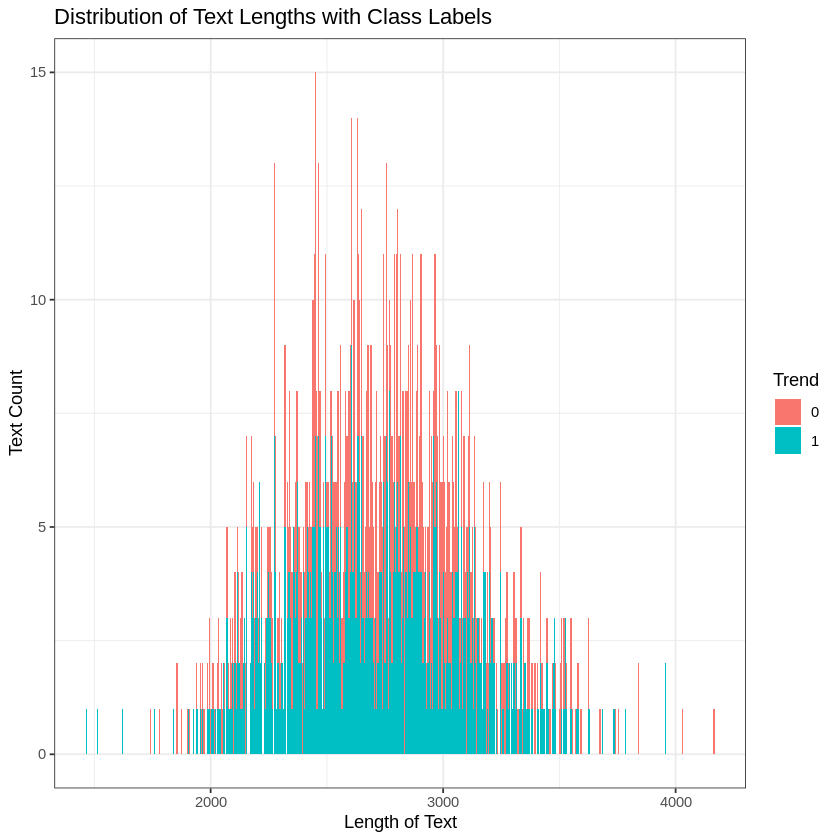

In [ ]:
# Plotting character distribution

merged_df$TextLength <- nchar(merged_df$News)
summary(nchar(merged_df$News))

ggplot(merged_df, aes(x = TextLength, fill = Trend)) +
    theme_bw() +
    geom_histogram(binwidth = 5) +
    labs(y = "Text Count", x = "Length of Text",
    title = "Distribution of Text Lengths with Class Labels") 

In [ ]:
# Printing labels distribution

prop.table(table(merged_df$Trend))


        0         1 
0.4644269 0.5355731 

In this step I have investigated about the most frequent words in the dataset over the two labels. The two wordclouds show an interesting feature: the most frequent words associated with a decreasing trend are the figuring in the raising trend. This can lead to issues due to the fact that, in the "News Headlines" domain, the most frequent words are also the most important. Let's consider these last months during the pandemic: the words "covid-19" and "vaccine" were probably the most frequent in every news source and, therefore, they have also influenced the stock market trend. For this purpose I decided to store the top 1000 words for both classes in order to select them as interesting for the machine learning algorithms.

In [ ]:
# Searching for most frequent words in the two classes

df.raise <- merged_df[merged_df$Trend == 1,]
df.decrease <- merged_df[merged_df$Trend == 0,]

df.tokens.raise <- tokens(df.raise$News, what = "word", remove_numbers = TRUE, 
                       remove_punct = TRUE, remove_symbols = TRUE)
df.tokens.raise <- tokens_tolower(df.tokens.raise)
df.tokens.raise <- tokens_select(df.tokens.raise, stopwords("SMART"), selection = "remove")
df.tokens.raise <- tokens_wordstem(df.tokens.raise, language = "english")

df.tokens.decrease <- tokens(df.decrease$News, what = "word", remove_numbers = TRUE, 
                       remove_punct = TRUE, remove_symbols = TRUE)
df.tokens.decrease <- tokens_tolower(df.tokens.decrease)
df.tokens.decrease <- tokens_select(df.tokens.decrease, stopwords("SMART"), selection = "remove")
df.tokens.decrease <- tokens_wordstem(df.tokens.decrease, language = "english")

In [ ]:
# Selecting the top 2500 words of the two classes

df.tokens.dfm.raise <- dfm_select(dfm(df.tokens.raise), names(topfeatures(dfm(df.tokens.raise), n = 2500)))
df.tokens.dfm.decrease <- dfm_select(dfm(df.tokens.decrease), names(topfeatures(dfm(df.tokens.decrease), n = 2500)))

Warning message:
“colorsmax.wordsrandom.colorrot.per is deprecated; use colormax_wordsrandom_colorrotation instead”


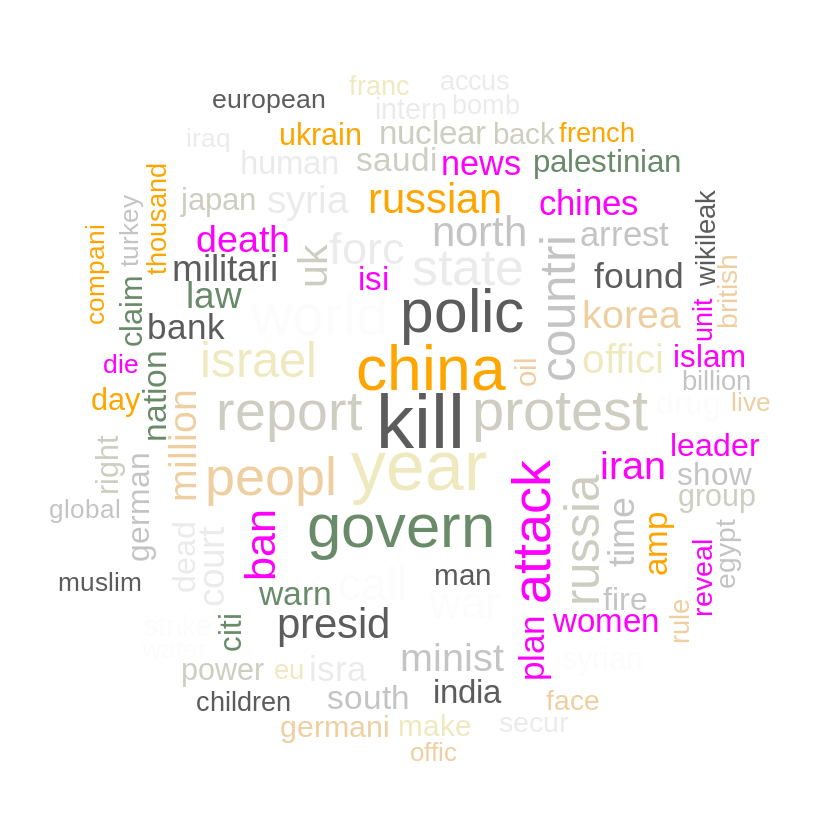

In [ ]:
textplot_wordcloud(df.tokens.dfm.raise , random.color = TRUE, rot.per = 0.25, max.words = 100,
                   colors = sample(colors()[2:512], 10))

Warning message:
“colorsmax.wordsrandom.colorrot.per is deprecated; use colormax_wordsrandom_colorrotation instead”


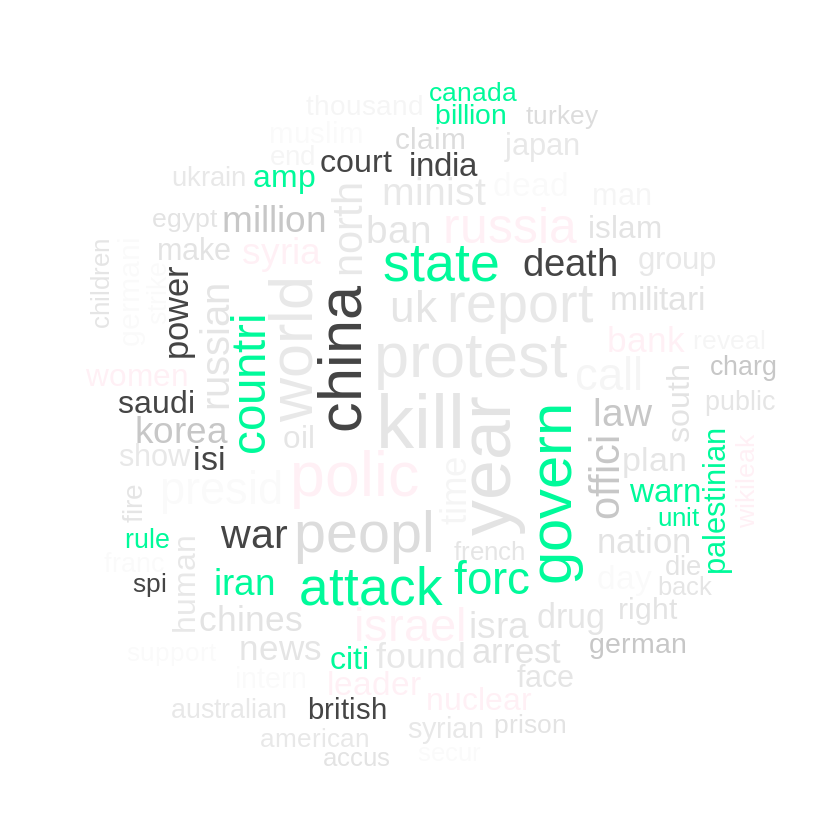

In [ ]:
textplot_wordcloud(df.tokens.dfm.decrease, max.words = 100, random.color = TRUE, rot.per = 0.25, 
                   colors = sample(colors()[2:512], 10))

In [ ]:
# Building the list of words to select by using the words obtained in the previous step and the financial words

frequent.words <- unique(append(colnames(df.tokens.dfm.decrease), colnames(df.tokens.dfm.raise)))
select.tokens <- c(lexicon$Constraining, lexicon$Litigious, lexicon$Negative, lexicon$Positive, lexicon$WeakModal, frequent.words, lexicon$StrongModal)

The document-frequence-matrix is built considering the most frequent words computed in the previous step, the words belonging to the financial lexicon (it is reasonable that they are important to characterize the news headlines from a financial point of view) and the stopwords. The lexicon is used to assign a score for each category to the pre-processed news.

In [ ]:
# Building the tokens list and computing the score of each sentence by using the financial lexicon

df.tokens <- tokens(merged_df$News, what = "word", remove_numbers = TRUE, 
                       remove_punct = FALSE, remove_symbols = TRUE)
df.tokens <- tokens_tolower(df.tokens)
df.tokens <- tokens_select(df.tokens, select.tokens, selection = "keep")
df.tokens <- tokens_select(df.tokens, stopwords("SMART"), selection = "remove")

dfm.tokens.before.stem <- dfm(df.tokens)

merged_df$Negative <- apply(dfm.tokens.before.stem, 1, function(x) sum(x * colnames(dfm.tokens.before.stem) %in% lexicon$Negative) / sum(x))
merged_df$Positive <- apply(dfm.tokens.before.stem, 1, function(x) sum(x * colnames(dfm.tokens.before.stem) %in% lexicon$Positive / sum(x)))
merged_df$Uncertainty <- apply(dfm.tokens.before.stem, 1, function(x) sum(x * colnames(dfm.tokens.before.stem) %in% lexicon$Uncertainty / sum(x)))
merged_df$Litigious <- apply(dfm.tokens.before.stem, 1, function(x) sum(x * colnames(dfm.tokens.before.stem) %in% lexicon$Litigious / sum(x)))
merged_df$Constraining <- apply(dfm.tokens.before.stem, 1, function(x) sum(x * colnames(dfm.tokens.before.stem) %in% lexicon$Constraining / sum(x)))

df.tokens <- tokens_wordstem(df.tokens, language = "english")
merged_df$Tokens <- as.list(df.tokens)

As we have shown before, the two classes share the most frequent words. In order to add variety, I decided to select the top 1000 words which consists in uni-grams and customized contextual bi-grams; in particular I exploited the information computed during the pre-preocessing phase ($Hist\_trend$) to characterize the context in which a word is used inside a headline. Each word of each document is concatenated with the string "raising_trend" whether the hystorical trend is raising, or with "decreasing_trend" if not. Thanks to that, machine learning algorithms should be more capable of capturing the context in which a certain word is used. For istance: the word "vaccine" can assume different roles (in the context of market trend) based on the historical trend. If the trend is raising, the word "vaccine" should reflect the optimism of the markets and vice versa.

In [ ]:
# Building the customized contextual bi-gram model

original.tokens <- merged_df$Tokens
merged_df[merged_df$Hist_Trend == 1, ]$Tokens <- merged_df[merged_df$Hist_Trend == 1, ]$Tokens %>% lapply(function(x) paste(x, "raising_trend", sep = "_"))
merged_df[merged_df$Hist_Trend == 0, ]$Tokens<- merged_df[merged_df$Hist_Trend == 0, ]$Tokens %>% lapply(function(x) paste(x, "decreasing_trend", sep = "_"))
merged_df$Tokens <- mapply(append, merged_df$Tokens, original.tokens, SIMPLIFY=FALSE)

Warning message:
“colorsmax.wordsrandom.colorrot.per is deprecated; use colormax_wordsrandom_colorrotation instead”


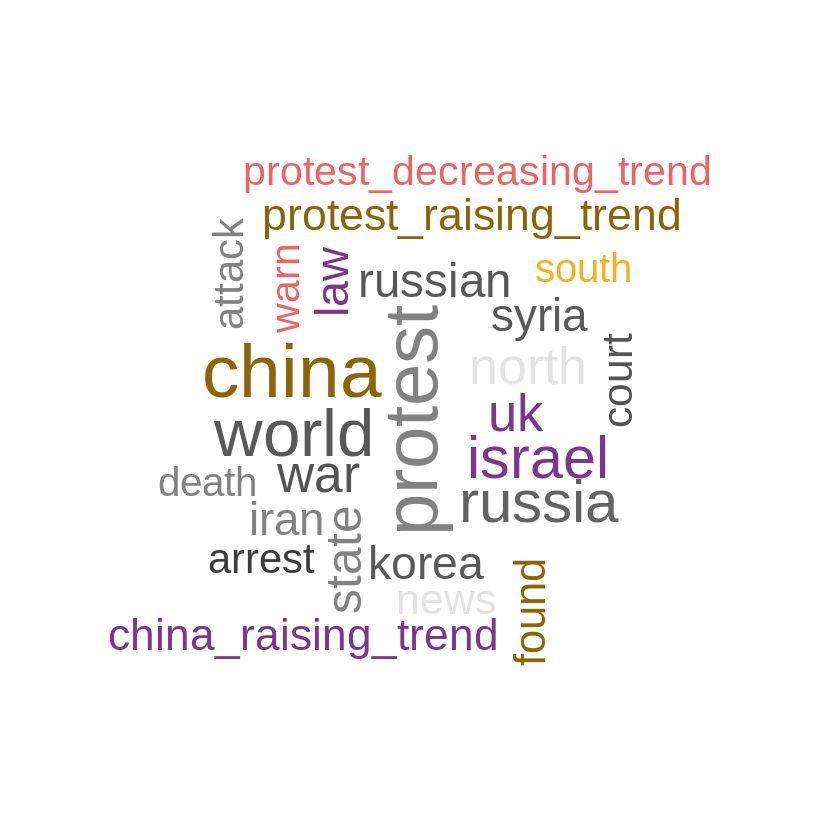

In [ ]:
df.tokens.dfm <- dfm_select(dfm(as.tokens(merged_df$Tokens)), names(topfeatures(dfm(as.tokens(merged_df$Tokens)), n = 1000)))
textplot_wordcloud(df.tokens.dfm, random.color = TRUE, rot.per = 0.25, max.words = 25,
                   colors = sample(colors()[2:512], 10))

## **Word/Document Embedding**

In this section I used tf-idf and SVD (Singular Value Decomposition) to represent each document of the dataset. 

In [ ]:
# tf-idf functions

term.frequency <- function(row) {
    row / sum(row)
}

inverse.doc.freq <- function(col) {
    corpus.size <- length(col)
    doc.count <- length(which(col > 0))
    log10(corpus.size / doc.count)
}

tf.idf <- function(tf, idf) {
    tf * idf
}

In [ ]:
# Building the tf-df matrix 

df.tokens.matrix <- as.matrix(df.tokens.dfm)
df.tokens.df <- apply(df.tokens.matrix, 1, term.frequency)
df.tokens.idf <- apply(df.tokens.matrix, 2, inverse.doc.freq)
df.tokens.tfidf <- apply(df.tokens.df, 2, tf.idf, idf = df.tokens.idf)
df.tokens.tfidf <- t(df.tokens.tfidf)
rownames(df.tokens.tfidf) <- gsub('text','', rownames(df.tokens.tfidf))
df.tokens.tfidf <- df.tokens.tfidf[order(as.numeric(rownames(df.tokens.tfidf))), ]

head(df.tokens.tfidf, 5)

,israel_decreasing_trend,plan_decreasing_trend,palestinian_decreasing_trend,arab_decreasing_trend,east_decreasing_trend,million_decreasing_trend,pakistan_decreasing_trend,india_decreasing_trend,death_decreasing_trend,record_decreasing_trend,⋯,edward,ebola_decreasing_trend,nsa_raising_trend,nsa,snowden_decreasing_trend,nsa_decreasing_trend,snowden,snowden_raising_trend,crimea,mh
1,0.018029439,0.007698939,0.026413478,0.008519741,0.015455139,0.0156404,0.012381624,0.01015062,0.010218443,0.008299882,⋯,0,0,0,0,0,0,0,0,0,0
2,0.017139096,0.000000000,0.006277277,0.000000000,0.000000000,0.0000000,0.017655279,0.00000000,0.004856914,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
3,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,0.000000000,0.00000000,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
4,0.009776527,0.008349553,0.000000000,0.000000000,0.008380603,0.0000000,0.006713979,0.00000000,0.000000000,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0
5,0.009776527,0.000000000,0.007161401,0.000000000,0.000000000,0.0000000,0.006713979,0.00000000,0.011081973,0.000000000,⋯,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Searching for incomplete cases (the sentence without words are represented with all 0s) 

incomplete.cases <- which(!complete.cases(df.tokens.tfidf))
merged_df$News[incomplete.cases]
df.tokens.tfidf[incomplete.cases,] <- rep(0.0, ncol(df.tokens.tfidf))

character(0)

In [ ]:
install.packages("irlba")
library(irlba)

In [ ]:
# Performing SVD

df.ilrba <- irlba(t(df.tokens.tfidf), nv = 75, tol = 1e-7)
df.svd <- data.frame(Trend = merged_df$Trend, df.ilrba$v)
df.svd$Trend <- as.factor(merged_df$Trend)
levels(df.svd$Trend) <- c("decrease", "raise")
head(df.svd)

,Trend,X1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X66,X67,X68,X69,X70,X71,X72,X73,X74,X75
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,decrease,-0.02561521,0.02594191,0.003146937,-0.023763224,-0.024478110,0.007571384,0.020017894,-0.07602454,-0.007489231,⋯,0.0035905973,0.0145331211,0.0034862072,-0.015431514,0.03094014,0.03162119,0.002639325,0.045864178,7.596750e-04,0.013616850
2,raise,-0.02560023,0.02748486,0.001065854,-0.021036587,0.002481814,0.013634855,0.014262639,-0.04605665,-0.014851638,⋯,0.0146598054,0.0121285868,0.0276898144,-0.019376386,0.01858186,-0.01515223,0.012237861,0.036678175,-8.614098e-03,0.006989770
3,decrease,-0.02542003,-0.02388601,0.012260560,0.001670754,-0.024805593,0.028448432,-0.008580401,-0.01653297,0.014676358,⋯,-0.0650007488,-0.0076306718,-0.0258900325,-0.014781130,0.02829392,0.01802912,-0.022504238,-0.008128347,-3.903984e-02,0.003854124
4,decrease,-0.02581183,0.02614113,-0.009147348,-0.023264543,0.009573591,0.008087096,0.030159669,-0.01888876,0.003033558,⋯,0.0003748393,-0.0002141224,-0.0055608993,0.009940061,0.01025297,-0.01532610,-0.020136746,-0.020822080,6.985168e-05,0.043003350
5,decrease,-0.02566876,0.02720065,0.010197290,-0.009578704,-0.007167939,0.027622671,0.015311840,-0.04309024,-0.019650614,⋯,-0.0235149741,-0.0194080883,0.0594675242,-0.010776116,0.01596282,-0.01332306,-0.031742136,0.034625675,-6.710726e-03,-0.015907798
6,decrease,-0.02587241,0.02604220,0.008932013,-0.004343961,-0.023980897,0.018847091,-0.006542404,-0.03035272,-0.003245176,⋯,0.0102788772,-0.0075188655,-0.0006476672,-0.037913514,-0.02121843,0.01470075,0.005179910,0.022046035,2.656928e-02,0.019148024


As we can see, the plot does not show any relevant pattern that can be exploited to better discriminate the Stock Market Trends given the News Headlines. 
N.B. The best proposals to solve this task have an accuracy lesser than 60%

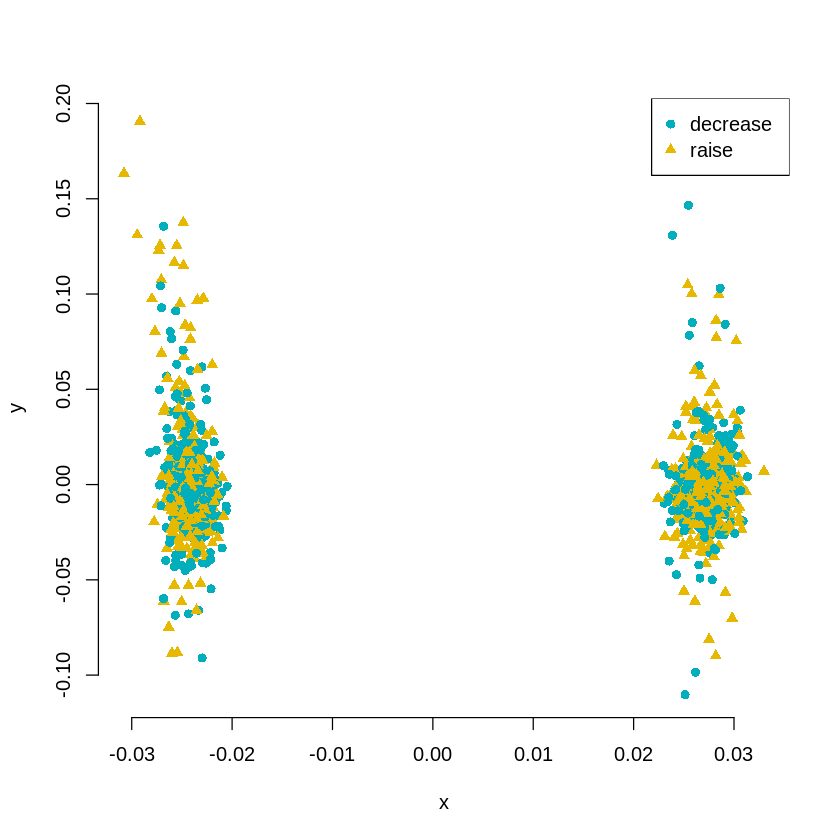

In [ ]:
# Plotting documents (over the labels) in the SVD space

colors <- c("#00AFBB", "#E7B800")
colors <- colors[as.numeric(df.svd$Trend)]

shapes = c(16, 17) 
shapes <- shapes[as.numeric(df.svd$Trend)]

plot(x = df.svd[,3], y = df.svd[,4], frame = FALSE,
     xlab = "x", ylab = "y",
     col = colors, pch = shapes)
legend("topright", legend = levels(df.svd$Trend),
      col =  c("#00AFBB", "#E7B800"),
      pch = c(16, 17) )

## **Evaluation with a simple Machine Learning algorithm** 

Given the chaotic representation of documents in the SVD space, I decided to evaluate the performances by using the "rpart" method. I used this very fast method in order to check the quality of the pre-processing and embedding in order to choose the best combination.

In [ ]:
# Adding the scores obtained with the lexicon analysis

df.svd$Negative <- merged_df$Negative
df.svd$Positive <- merged_df$Positive
df.svd$Litigious <- merged_df$Litigious
df.svd$Uncertainty <- merged_df$Uncertainty
df.svd$Constraining <- merged_df$Constraining

In [ ]:
set.seed(42)
cv.cntrl <- trainControl(method = "timeSlice", initialWindow = round(0.8 * nrow(df.svd), digits = 0), horizon = round(0.2 * nrow(df.svd), digits = 0), classProbs = T, fixedWindow = T)
rpart.cv.1 <- train(Trend ~ ., data = df.svd, method = "rpart", trControl = cv.cntrl, tuneLength = 15)
print(rpart.cv.1)

CART 

1518 samples
  80 predictor
   2 classes: 'decrease', 'raise' 

No pre-processing
Resampling: Rolling Forecasting Origin Resampling (304 held-out with a fixed window) 
Summary of sample sizes: 1214 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa     
  0.001891253  0.5592105  0.11811569
  0.002836879  0.5592105  0.11811569
  0.003782506  0.5657895  0.13157895
  0.004255319  0.5657895  0.13157895
  0.004964539  0.5657895  0.13127814
  0.005673759  0.5460526  0.09336100
  0.006382979  0.5394737  0.07926618
  0.007092199  0.5197368  0.03880804
  0.007943262  0.5131579  0.02496533
  0.008510638  0.5065789  0.01041667
  0.009219858  0.5164474  0.02359727
  0.011347518  0.5164474  0.02359727
  0.014184397  0.5427632  0.08091178
  0.022695035  0.5427632  0.07802409
  0.025531915  0.5427632  0.07802409

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.004964539.


## **Evaluation with LSTM and xgbDART**

Eventually, I decided to exploit LSTM and xgbDART to solve the task. The dataset is divided in training and test set (80% and 20%) without shuffling according as per kaggle competition specifications.

In [ ]:
# Preparing data for splitting

levels(df.svd$Trend) <- c(0, 1)

df.svd$Trend <- as.numeric(df.svd$Trend)
df.svd$Trend <- df.svd$Trend - 1

cutoff = round(0.8 * nrow(df.svd), digits = 0)

In [ ]:
# Splitting train-test

supervised <- apply(df.svd, 2, as.numeric)

train <- supervised[1:cutoff, ]
test <- supervised[(cutoff + 1):nrow(supervised), ]

In [ ]:
# Building train/test features/labels

x_train <- array(train[, 2:ncol(train)], dim = c(nrow(train), 1, ncol(df.svd) - 1))
y_train <- array(train[, 1], dim = c(nrow(train), 1))

x_test <- array(test[, 2:ncol(train)], dim = c(nrow(test), 1, ncol(df.svd) - 1))
y_test <- array(test[, 1], dim = c(nrow(test), 1))

print(dim(x_train))
print(dim(y_train))
print(dim(x_test))
print(dim(y_test))

[1] 1214    1   80
[1] 1214    1
[1] 304   1  80
[1] 304   1


In [ ]:
# Extracting dimension and defining hyperparameters

X_shape2 <- dim(x_train)[2]
X_shape3 <- dim(x_train)[3]     

batch_size <- 2             
units <- 64
Epochs <- 500  

In [ ]:
install.packages("keras")
library(keras)

In [ ]:
# Model definition

set.seed(57)

model <- keras_model_sequential() 
model%>%
  layer_lstm(units = units, stateful = T, batch_size = batch_size, batch_input_shape = c(batch_size, X_shape2, X_shape3)) %>%
  layer_dropout(rate = 0.5) %>%
  layer_dense(units = 1, activation = 'tanh')

model %>% compile(
  loss = 'mean_squared_error',
  optimizer = optimizer_adam(lr = 0.0003, decay = 7e-6),
  metrics = c('accuracy')
)
model

Model
Model: "sequential_27"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
lstm_27 (LSTM)                      (2, 64)                         37120       
________________________________________________________________________________
dropout_27 (Dropout)                (2, 64)                         0           
________________________________________________________________________________
dense_27 (Dense)                    (2, 1)                          65          
Total params: 37,185
Trainable params: 37,185
Non-trainable params: 0
________________________________________________________________________________



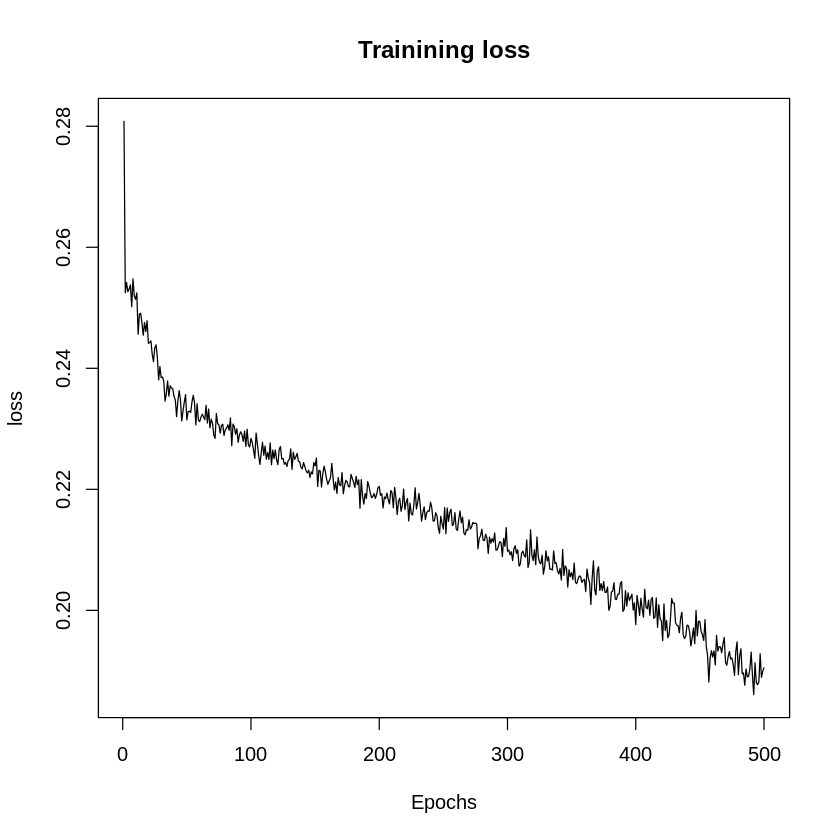

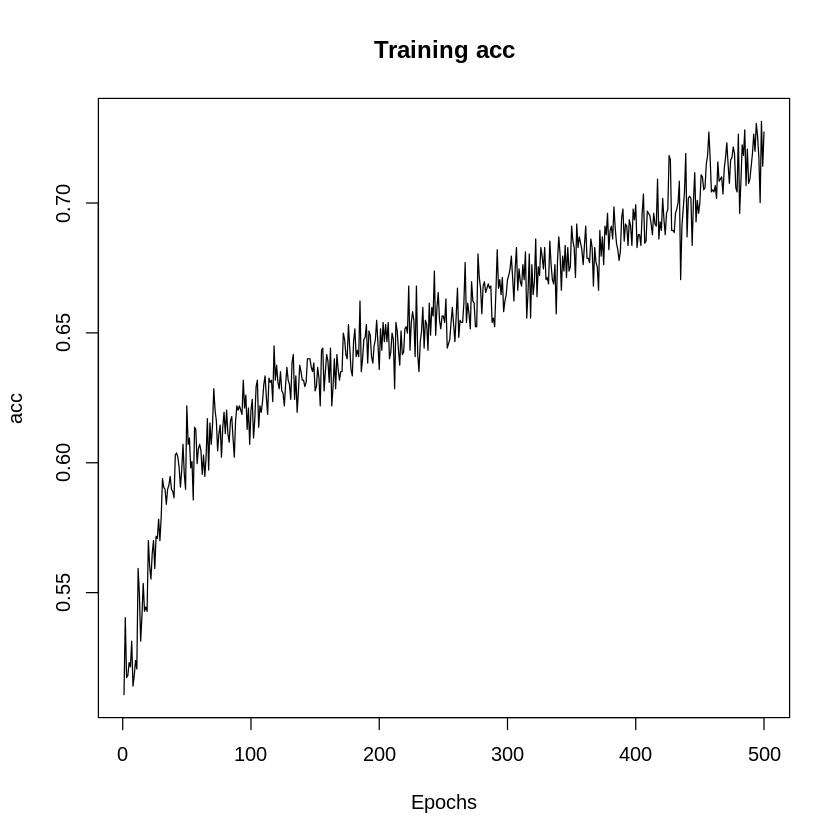

In [ ]:
# Training loop

hist_train_loss <- c()
hist_train_acc <- c() 
epochs_space <- seq(from = 1, to = Epochs, by = 1)
valid.acc <- 0

for(i in 1:Epochs){
    hist <- model %>% fit(x_train, y_train, epochs = 1, batch_size = batch_size, verbose = F, shuffle = F)
    model %>% reset_states()
    hist_train_loss <- append(hist_train_loss, hist$metrics$loss[1])
    hist_train_acc <- append(hist_train_acc, hist$metrics$accuracy[1])
    pred <- round(predict(model, x_test, batch_size = batch_size))
    acc <- sum(pred == y_test) / length(pred)
    if (valid.acc < acc){
        best.pred <- pred
        valid.acc <- acc
    }
}

plot(x = epochs_space, y = hist_train_loss, main = 'Trainining loss', xlab = 'Epochs', ylab = 'loss', type = 'l')
plot(x = epochs_space, y = hist_train_acc, main = 'Training acc', xlab = 'Epochs', ylab = 'acc', type = 'l')

In [ ]:
# Results

print(confusionMatrix(data = factor(best.pred), reference = factor(y_test)))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  63  44
         1  85 112
                                          
               Accuracy : 0.5757          
                 95% CI : (0.5179, 0.6319)
    No Information Rate : 0.5132          
    P-Value [Acc > NIR] : 0.0167239       
                                          
                  Kappa : 0.1447          
                                          
 Mcnemar's Test P-Value : 0.0004286       
                                          
            Sensitivity : 0.4257          
            Specificity : 0.7179          
         Pos Pred Value : 0.5888          
         Neg Pred Value : 0.5685          
             Prevalence : 0.4868          
         Detection Rate : 0.2072          
   Detection Prevalence : 0.3520          
      Balanced Accuracy : 0.5718          
                                          
       'Positive' Class : 0               
                              

The results obtained with LSTM are already acceptable considering the performances obtained on this dataset which I will discuss in the final section. However, even better results have been achieved with xgboost.

In [ ]:
install.packages("xgboost")
library(xgboost)

In [ ]:
# Data prepration for xgboost

train <- df.svd[1:cutoff, ]
levels(train$Trend) <- c(0, 1)
train$Trend <- as.factor(train$Trend)

test <- df.svd[(cutoff + 1):nrow(df.svd), ]
levels(test$Trend) <- c(0, 1)
test$Trend <- as.factor(test$Trend)

In [ ]:
# train/test xgboost

train.set <- xgboost::xgb.DMatrix(as.matrix(train[,2:ncol(train)]), label = as.matrix(train[,1]), missing = NA)
test.set <- xgboost::xgb.DMatrix(as.matrix(test[,2:ncol(test)]), missing = NA)

set.seed(57)
model.xgbDART <- xgboost::xgb.train(list(max_depth = 10,
                                        eta = 0.3,
                                        rate_drop = 0.5,
                                        skip_drop = 0.05,
                                        min_child_weight = 1,
                                        gamma = 0,
                                        subsample = 1,
                                        colsample_bytree = 0.6),
                                        data = train.set,
                                        nrounds = 250,
                                        objective = "multi:softmax",
                                        num_class = 2,
                                        booster= "dart")
pred <- predict(model.xgbDART, test.set)
confusionMatrix(data = factor(pred), reference = factor(as.matrix(test[,1])))

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0  64  37
         1  84 119
                                          
               Accuracy : 0.602           
                 95% CI : (0.5445, 0.6574)
    No Information Rate : 0.5132          
    P-Value [Acc > NIR] : 0.001137        
                                          
                  Kappa : 0.1969          
                                          
 Mcnemar's Test P-Value : 2.892e-05       
                                          
            Sensitivity : 0.4324          
            Specificity : 0.7628          
         Pos Pred Value : 0.6337          
         Neg Pred Value : 0.5862          
             Prevalence : 0.4868          
         Detection Rate : 0.2105          
   Detection Prevalence : 0.3322          
      Balanced Accuracy : 0.5976          
                                          
       'Positive' Class : 0               
                              

## **Conclusions**

In this last section I want to give a short review on the literature available on-line. dsciacca used LSTM and performed an analysis on the subjectivity/objectivity of the news headlines obtaining 55% accuracy https://github.com/dsciacca/predicting-stocks-w-headlines. Velay et.all in "Using NLP on news headlines to predict index trends" reaches an accuracy equal to 57%  with logistic regression using different types of embeddings (word embedding, word2vec and tf-idf). Kalshani in "Stock Market Prediction using Daily News Headlines" uses LSTM with 52% as best accuracy. Zhu in "Predicting Stock Price Trends using News Headlines" exploits news-stock correlation and he reaches an accuracy equal to 53.42%. Poulos in "Predicting Stock Market Movement with Deep RNNs" used GRU and he reaches a best accuracy equal to 54%. In conclusion, the accuracy obtained in this work outperforms the previous ones.

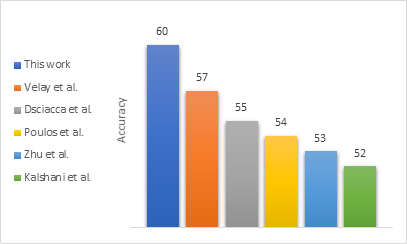